# SaySco App Project


In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

### 1. Acquiring and Filtering Essay Data

#### a. Taking data from file
In this step, first is we take the training and validation data from the dataset. <br>
After that, we filter out the column that will not be used in the analyais. <br>
Then lastly, we remove extra whitespaces from the essay data from both training and validation <br>

In [3]:
def open_data(filename):
    df = pd.read_excel("./data/" + filename)
    # df = df[(df['essay_set'] > 2) & (df['essay_set'] < 7)]
    df = df[(df['essay_set'] == 3)]
    return df

df_train =open_data("training_set_rel3.xlsx")
df_val = open_data("valid_set.xlsx")
val_score = pd.read_csv("./data/valid_sample_submission_2_column.csv")

df_val.rename(columns={"domain1_predictionid": "prediction_id"}, inplace=True)
df_val = pd.merge(df_val, val_score, on="prediction_id", how="left")

df_train['essay'] = df_train['essay'].apply(lambda x: x.strip())
df_val['essay'] = df_val['essay'].apply(lambda x: x.strip())


print("This is the train data looks like:")
print(df_train.head(5))

print("\nThis is the validation data looks like:")
print(df_val.head(5))


This is the train data looks like:
      essay_id  essay_set                                              essay  \
3583      5978          3  The features of the setting affect the cyclist...   
3584      5979          3  The features of the setting affected the cycli...   
3585      5980          3  Everyone travels to unfamiliar places. Sometim...   
3586      5981          3  I believe the features of the cyclist affected...   
3587      5982          3  The setting effects the cyclist because of the...   

      rater1_domain1  rater2_domain1  rater3_domain1  domain1_score  \
3583             1.0             1.0             NaN            1.0   
3584             2.0             2.0             NaN            2.0   
3585             1.0             1.0             NaN            1.0   
3586             1.0             1.0             NaN            1.0   
3587             2.0             2.0             NaN            2.0   

      rater1_domain2  rater2_domain2  domain2_score  ... 

#### b. Preparing arrays
In this step, we declare convert the dataframes into numpy arrays.

In [4]:
# acquire train data
# train_essay_id = df_train['essay_id'].to_numpy()
train_essay_set = df_train['essay_set'].to_numpy()
train_essays = df_train['essay'].to_numpy()
train_score = df_train['domain1_score'].to_numpy()

# convert train data
# train_essay_id = train_essay_id.astype('int32')
train_essay_set = train_essay_set.astype('int32')
train_score = train_score.astype('float32')

# acquire validation data
# validation_essay_id = df_val['essay_id'].to_numpy()
validation_essay_set = df_val['essay_set'].to_numpy()
validation_essays = df_val['essay'].to_numpy()
validation_score = df_val['predicted_score'].to_numpy()

# convert train data
# validation_essay_id = validation_essay_id.astype('int32')
validation_essay_set = validation_essay_set.astype('int32')
validation_score = validation_score.astype('float32')


print("Train set shape: ", train_essay_set.shape, "  Data Type: ", train_essay_set.dtype)
print("Train score shape: ", train_score.shape, "  Data Type: ", train_score.dtype)

print("Validation set shape: ", validation_essay_set.shape, "  Data Type: ", validation_essay_set.dtype)
print("Validation score shape: ", validation_score.shape, "  Data Type: ", validation_score.dtype)

Train set shape:  (1726,)   Data Type:  int32
Train score shape:  (1726,)   Data Type:  float32
Validation set shape:  (568,)   Data Type:  int32
Validation score shape:  (568,)   Data Type:  float32


### 2. Defining Tokenizer and Vocabulary

#### a. Defining Tokenizer

In [5]:
MAX_SENTLEN = 50 # maximum sentence length
MAX_SENTNUM = 100 # maximum number of sentences

def tokenizer(text):
    text = re.sub('(http[s]?://)?((www)\.)?([a-zA-Z0-9]+)\.{1}((com)(\.(cn))?|(org))', '<url>', text) # remove links
    text = re.sub(r'\.{3,}(\s+\.{3,})*', '...', text) # ellipsis handling (..., ???, !!!) --> (., ?. !)
    text = re.sub(r'\?{2,}(\s+\?{2,})*', '?', text) 
    text = re.sub(r'\!{2,}(\s+\!{2,})*', '!', text)

    # tokenization with NLTK, creating list of words & punctuation
    tokens = nltk.word_tokenize(text)
    # print(tokens)

    for index, token in enumerate(tokens):
        if token == '@' and (index+1) < len(tokens):
            tokens[index+1] = '@' + re.sub('[0-9]+.*', '', tokens[index+1])
            tokens.pop(index)

    # rejoining tokens : token list --> string
    text = " ".join(tokens)
    
    # call tokenize_to_sentences function
    sent_tokens = tokenize_to_sentences(text, MAX_SENTLEN)

    return sent_tokens  

def tokenize_to_sentences(text, max_sentlength):
    # split text into sentences
    sents = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\!|\?)\s', text)

    processed_sents = []

    # iterate through sentences
    for sent in sents:
        if re.search(r'(?<=\.{1}|\!|\?|\,)(@?[A-Z]+[a-zA-Z]*[0-9]*)', sent):
            s = re.split(r'(?=.{2,})(?<=\.{1}|\!|\?|\,)(@?[A-Z]+[a-zA-Z]*[0-9]*)', sent)
            ss = " ".join(s)
            ssL = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\!|\?)\s', ss)
            processed_sents.extend(ssL)
        else:
            processed_sents.append(sent)
    
    # print(processed_sents)
    
    sent_tokens = []
    for sent in processed_sents:
        shorten_sents_tokens = shorten_sentence(sent, max_sentlength)
        sent_tokens.extend(shorten_sents_tokens)

    return sent_tokens

def shorten_sentence(sent, max_sentlen):
    new_tokens = []
    sent = sent.strip()
    tokens = nltk.word_tokenize(sent)
    if len(tokens) > max_sentlen: # if tokens larger than maximum sentence length, shorten it
        split_keywords = ['because', 'but', 'so', 'You', 'He', 'She', 'We', 'It', 'They', 'Your', 'His', 'Her']
        k_indexes = [i for i, key in enumerate(tokens) if key in split_keywords]
        processed_tokens = []
        if not k_indexes:
            num = (int) (len(tokens) / max_sentlen)
            k_indexes = [(i+1)*max_sentlen for i in range(num)]

        processed_tokens.append(tokens[0:k_indexes[0]])
        len_k = len(k_indexes)
        for j in range(len_k-1):
            processed_tokens.append(tokens[k_indexes[j]:k_indexes[j+1]])
        processed_tokens.append(tokens[k_indexes[-1]:])

        for token in processed_tokens:
            if len(token) > max_sentlen:
                num = (int) (len(token) / max_sentlen)
                s_indexes = [(i+1)*max_sentlen for i in range(num)]

                len_s = len(s_indexes)
                new_tokens.append(token[0:s_indexes[0]])
                for j in range(len_s-1):
                    new_tokens.append(token[s_indexes[j]:s_indexes[j+1]])
                new_tokens.append(token[s_indexes[-1]:])

            else:
                new_tokens.append(token)
    else: # if not, just return
        return [tokens]

    return new_tokens

#### b. Creating Vocabulary
NOTE (PLEASE READ):
1. If the 'saved_vocab.pkl' file already exist, just go straight to the LOAD SAVED VOCABULARY.
2. If not, go through functions bellow first.

In [6]:
def create_vocabulary(essays):
    total_words, unique_words = 0, 0
    word_freqs = {} # words dictionary

    for content in essays:
        content = tokenizer(content)
        for sentence in content:
            for word in sentence:
                word = word.lower() # lower word
                try:
                    word_freqs[word] += 1 # add the number of that particular word on the dictionary
                except KeyError:
                    unique_words += 1
                    word_freqs[word] = 1 # add word to the dictionary
                total_words += 1

    print(word_freqs)

    import operator
    sorted_word_freqs = sorted(word_freqs.items(), key=lambda item: item[1], reverse=True)
    print(sorted_word_freqs)

    vocab_size = 0
    for word, freq in sorted_word_freqs:
        if freq > 1:
            vocab_size += 1
    
    vocab = {'<pad>': 0, '<unk>': 1, '<num>': 2}
    vocab_len = len(vocab)
    index = vocab_len
    for word, _ in sorted_word_freqs[:vocab_size - vocab_len]:
        vocab[word] = index
        index += 1
    
    print("Total words: ", total_words)
    print("Unique words: ", unique_words)

    return vocab

vocab = create_vocabulary(train_essays)

print("Vocabulary size: ", len(vocab))
print("\nThis is the vocab looks like:")
print(vocab)

{'the': 16471, 'features': 1202, 'of': 4913, 'setting': 2258, 'affect': 878, 'cyclist': 3785, 'in': 3954, 'many': 487, 'ways': 283, '.': 10779, 'that': 2543, 'is': 2775, 'lact': 1, 'information': 43, 'on': 1403, 'were': 459, 'to': 4799, 'go': 277, 'and': 4822, 'lack': 283, 'water': 2441, 'this': 1468, 'was': 3606, 'a': 4106, 'problem': 93, 'because': 1157, 'he': 6302, 'needed': 73, 'for': 1122, 'his': 1875, 'trip': 155, 'directions': 239, 'affected': 807, 'negative': 57, 'way': 415, 'desert': 601, ',': 6353, 'which': 461, 'dry': 195, 'hot': 793, '“': 1964, 'i': 1020, 'traveling': 130, 'through': 514, 'high': 216, 'deserts': 225, 'california': 392, 'june': 387, '``': 476, '(': 201, 'kurmaskie': 267, '@': 916, 'num': 355, ')': 211, 'also': 734, 'temperature': 64, 'made': 434, 'every': 48, 'thing': 119, 'around': 271, 'him': 1875, 'brackish': 27, 'faling': 1, 'somewhere': 47, 'neighborhood': 34, 'two': 126, 'hundred': 43, 'degrees': 63, 'since': 147, 'there': 856, 'no': 725, 'escape': 5, 

In [8]:
# SAVE VOCABULARY
import pickle

with open('./saved_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [6]:
# LOAD SAVED VOCABULARY
import pickle

with open('./output/saved_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

### 3. Tokenizing Data


#### a. Tokenizing Essay Data
1. First, we are calling the tokenizer() function to turn the text essay data into sentence tokens form. <br>
2. Then we turn each word from the tokens into index of its own accoring to the vocabulary. <br>
3. The output of this function is a three-dimentional matrix of word indices of each sentence of each essay data.

In [9]:
def fit_tokenizer(essays, vocab, score):
    data_x, text = [], []
    num_hit, unk_hit, punc_hit, total = 0., 0., 0., 0.
    max_sentnum = -1 # maximum num of sentences
    max_sentlen = -1 # maximum sentence length

    num_regex = re.compile('^[+-]?[0-9]+\.?[0-9]*$')
    punc_regex = re.compile(r'[^\w\s]')

    for content in essays:
        sent_tokens = tokenizer(content) # transform individual essays into sentence tokens
        sent_tokens = [[w.lower() for w in s] for s in sent_tokens]

        sent_indices = [] 
        indices = []
        sentences = []
        words = []

        for sent in sent_tokens: # iterate through sentences in sent_tokens
            length = len(sent)
            
            if length > 0:
                if max_sentlen < length:
                    max_sentlen = length
                
                for word in sent: # iterate through words in each sentence
                    if bool(num_regex.match(word)): # if "word" is number, turn in into <num> index (2)
                        indices.append(vocab['<num>'])
                        num_hit += 1
                    elif bool(punc_regex.match(word)):
                        indices.append(vocab['<pad>'])
                        punc_hit += 1
                    elif word in vocab: # if "word" is in vocab, turn it into the word's index in vocab
                        indices.append(vocab[word])
                    else:
                        indices.append(vocab['<unk>'])
                        unk_hit += 1
                    total += 1
                    words.append(word)
                sentences.append(words)
                sent_indices.append(indices)
                indices = []
                words = []
        
        data_x.append(sent_indices)
        text.append(sentences)

        if max_sentnum < len(sent_indices):
            max_sentnum = len(sent_indices)
        
    return data_x, max_sentlen, max_sentnum, text

In [10]:
train_x, train_maxsentlen, train_maxsentnum, train_text = fit_tokenizer(train_essays, vocab, train_score)
val_x, val_maxsentlen, val_maxsentnum, val_text = fit_tokenizer(validation_essays, vocab, validation_score)

overall_maxlen = max(train_maxsentlen, val_maxsentlen)
overall_maxnum = max(train_maxsentnum, val_maxsentnum)

print("SUMMARY:")
print("Max sentence length train: ", train_maxsentlen)
print("Max num of sentences train: ", train_maxsentnum)
print("This is the first row of the train data looks like:")
print(train_x[0])
print("This is the first row of the train text looks like:")
print(train_text[0])

print("\nMax sentence length validation: ", val_maxsentlen)
print("Max num of sentences validation: ", val_maxsentnum)
print("This is the first row of the validation data looks like:")
print(val_x[0])
print("This is the first row of the validation text looks like:")
print(val_text[0])

print("\nOverall maximum sentence length: ", overall_maxlen)
print("Overall maximum num of sentences: ", overall_maxnum)

SUMMARY:
Max sentence length train:  50
Max num of sentences train:  22
This is the first row of the train data looks like:
[[3, 26, 7, 3, 18, 36, 3, 12, 11, 77, 119, 0], [3, 26, 7, 3, 18, 15, 36, 3, 12, 14, 3, 1, 7, 534, 24, 82, 9, 121, 8, 3, 120, 7, 16, 0], [23, 13, 10, 288, 28, 6, 353, 16, 29, 20, 206, 8, 136, 24, 82, 9, 121, 0]]
This is the first row of the train text looks like:
[['the', 'features', 'of', 'the', 'setting', 'affect', 'the', 'cyclist', 'in', 'many', 'ways', '.'], ['the', 'features', 'of', 'the', 'setting', 'that', 'affect', 'the', 'cyclist', 'is', 'the', 'lact', 'of', 'information', 'on', 'were', 'to', 'go', 'and', 'the', 'lack', 'of', 'water', '.'], ['this', 'was', 'a', 'problem', 'because', 'he', 'needed', 'water', 'for', 'his', 'trip', 'and', 'directions', 'on', 'were', 'to', 'go', '.']]

Max sentence length validation:  50
Max num of sentences validation:  21
This is the first row of the validation data looks like:
[[3, 26, 7, 3, 18, 36, 3, 12, 11, 61, 286, 90, 

#### b. Sequence and Padding Essay Data

In [11]:
def sequence_and_padding(index_sequences, scores, max_sentnum, max_sentlen):
    X = np.empty([len(index_sequences), max_sentnum, max_sentlen], dtype=np.int32)
    Y = np.empty([len(index_sequences), 1], dtype=np.float32)
    # mask = np.zeros([len(index_sequences), max_sentnum, max_sentlen], dtype=np.float32)

    for i in range(len(index_sequences)):
        sequence_ids = index_sequences[i]
        num = len(sequence_ids)

        for j in range(num):
            word_ids = sequence_ids[j]
            length = len(word_ids)
            # X_len[i] = length
            for k in range(length):
                wid = word_ids[k]
                # print wid
                X[i, j, k] = wid

            # Zero out X after the end of the sequence
            X[i, j, length:] = 0
            # Make the mask for this sample 1 within the range of length
            # mask[i, j, :length] = 1

        X[i, num:, :] = 0
        Y[i] = scores[i]
    
    return X, Y

In [12]:
X_train, y_train = sequence_and_padding(train_x, train_score, overall_maxnum, overall_maxlen)
X_val, y_val = sequence_and_padding(val_x, validation_score, overall_maxnum, overall_maxlen)

print("Train X sequence and padded: ", X_train.shape)
print("Train Y sequence and padded: ", y_train.shape)
print("This is the sequence and padded train data looks like:")
print(X_train[0])
print("This is the train label looks like:")
print(y_train[:5])

print("\nValidation X sequence and padded: ", X_val.shape)
print("Validation Y sequence and padded: ", y_val.shape)
print("This is the sequence and padded validation data looks like:")
print(X_val[0])
print("This is the validation label looks like:")
print(y_val[:5])


Train X sequence and padded:  (1726, 22, 50)
Train Y sequence and padded:  (1726, 1)
This is the sequence and padded train data looks like:
[[ 3 26  7 ...  0  0  0]
 [ 3 26  7 ...  0  0  0]
 [23 13 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
This is the train label looks like:
[[1.]
 [2.]
 [1.]
 [1.]
 [2.]]

Validation X sequence and padded:  (568, 22, 50)
Validation Y sequence and padded:  (568, 1)
This is the sequence and padded validation data looks like:
[[  3  26   7 ...   0   0   0]
 [  3 135 199 ...   0   0   0]
 [ 29  99   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
This is the validation label looks like:
[[1.]
 [1.]
 [1.]
 [3.]
 [2.]]


In [13]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))

print("Train X reshaped: ", X_train.shape)
print("Validation X reshaped: ", X_val.shape)

Train X reshaped:  (1726, 1100)
Validation X reshaped:  (568, 1100)


In [12]:
train_mean = train_score.mean()
train_std = train_score.std()

val_mean = validation_score.mean()
val_std = validation_score.std()

#### c. Converting Scores

In [14]:
score_ranges = {
    'type_1': (0, 3),
    'type_2': (0, 4),
}


def convert_score(scores, essay_set):
    scores_temp = scores.copy()

    for i, score in enumerate(scores_temp):
        if essay_set[i] == 3 or essay_set[i] == 4:
            low, high = score_ranges['type_1']
            scores_temp[i] = (score - low) / (high - low)
            # print(low, " ", high)
        else:
            low, high = score_ranges['type_2']
            scores_temp[i] = (score - low) / (high - low)

    return np.around(scores_temp).astype(int)

train_mean = y_train.mean(axis=0)

scaled_train_mean = convert_score(train_mean, train_essay_set)
y_train_converted = convert_score(y_train, train_essay_set)
y_val_converted = convert_score(y_val, validation_essay_set)



#### d. Build embedding table
NOTE (PLEASE READ):
1. If the 'emb_table.npy' file is already exist. Just go straight to LOAD EMBEDDING TABLE
2. If not, go through functions bellow.

In [17]:
# NOTE:
# Please download the glove embedding at https://nlp.stanford.edu/data/glove.6B.zip
# Just use only the glove.6B.50d.txt file

def load_word_embedding_dict(word_alphabet, embedd_dim=100):
    embedd_dim = -1
    embedd_dict = dict()

    embedding_path = "./glove.6B.50d.txt"

    with open(embedding_path, 'r', encoding="utf8") as file:
        for line in file:
            line = line.strip()
            if len(line) == 0:
                continue

            tokens = line.split()
            if embedd_dim < 0:
                embedd_dim = len(tokens) - 1
            else:
                assert (embedd_dim + 1 == len(tokens))
            embedd = np.empty([1, embedd_dim], dtype=np.float32)
            embedd[:] = tokens[1:]
            embedd_dict[tokens[0]] = embedd
    
    return embedd_dict, embedd_dim, True

def build_embedding_table(word_alphabet, emb_dict, emb_dim, caseless):
    scale = np.sqrt(3.0 / emb_dim)
    emb_table = np.empty([len(word_alphabet), emb_dim], dtype=np.float32)
    emb_table[0, :] = np.zeros([1, emb_dim])
    oov_num = 0
    for word, index in word_alphabet.items():
        ww = word.lower() if caseless else word
        # show oov ratio
        if ww in emb_dict:
            emb = emb_dict[ww]
        else:
            emb = np.random.uniform(-scale, scale, [1, emb_dim])
            oov_num += 1
        emb_table[index, :] = emb
    oov_ratio = float(oov_num)/(len(word_alphabet)-1)
    print("OOV number = %s, OOV ratio = %f" % (oov_num, oov_ratio))

    return emb_table

emb_dim = 100
emb_dict, emb_dim, _ = load_word_embedding_dict(vocab, emb_dim)
emb_table = build_embedding_table(vocab, emb_dict, emb_dim, caseless=True)

print(emb_table)
print(emb_table.shape)

OOV number = 210, OOV ratio = 0.070994
[[-0.0541394   0.081433   -0.17970179 ... -0.17062955 -0.1918844
  -0.06343652]
 [ 0.072617   -0.51393     0.4728     ... -0.18907    -0.59021
   0.55559   ]
 [ 0.08454939  0.2328925  -0.03147252 ...  0.22814293 -0.13838986
   0.02304671]
 ...
 [-0.9166      0.76511    -0.66093    ... -1.2757     -0.54513
   0.37287   ]
 [ 0.18994783 -0.2084108  -0.10736417 ...  0.06200255 -0.22101429
  -0.07178171]
 [ 0.36582    -0.43975    -0.35016    ...  0.8687      0.68687
   0.96048   ]]
(2959, 50)


In [19]:
# SAVE EMBEDDING TABLE
np.save('./emb_table.npy', emb_table)

In [23]:
# LOAD EMBEDDING TABLE
# emb_table = np.load('./output/emb_table.npy')
emb_table = np.asarray(np.load('./output/emb_table.npy'))
print(emb_table.shape[1])

50


### 4. Creating Model

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Dropout, Reshape, TimeDistributed, Conv1D, LSTM, Dense
from keras.models import Model
from keras.optimizers import RMSprop
from zeromasking import ZeroMaskedEntries
from softattention import Attention
from keras import backend 

def build_model(
        vocab_size, 
        maxnum,
        maxlen,
        embedding_dim,
        embedding_weights,
):
    num = maxnum
    len = maxlen

    dropout = 0.5
    nb_filters = 100
    filter1_len = 5
    lstm_units = 100

    word_input = Input(shape=(num * len,), dtype='int32', name='word_input')
    x = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=num * len, weights=embedding_weights, mask_zero=True, name='x')(word_input)
    x_maskedout = ZeroMaskedEntries(name='x_maskedout')(x)
    drop_x = Dropout(dropout, name='drop_x')(x_maskedout)

    resh_W = Reshape((num, len, embedding_dim), name='resh_W')(drop_x)

    zcnn = TimeDistributed(Conv1D(nb_filters, filter1_len, padding='valid'), name='zcnn')(resh_W)

    avg_zcnn = TimeDistributed(Attention(), name='avg_zcnn')(zcnn)

    hz_lstm = LSTM(lstm_units, return_sequences=True, name='hz_lstm')(avg_zcnn)

    avg_hz_lstm = Attention(name='avg_hz_lstm')(hz_lstm)

    y = Dense(units=1, activation='sigmoid', name='output')(avg_hz_lstm)

    model = Model(inputs=word_input, outputs=y)

    model.summary()

    model.compile(loss='mse', optimizer=RMSprop(lr=1e-4), metrics=['acc'])

    return model



In [23]:
emb_dim = emb_table.shape[1]
emb_table = [emb_table]

model = build_model(len(vocab), overall_maxnum, overall_maxlen, embedding_dim=emb_dim, embedding_weights=emb_table)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_input (InputLayer)     [(None, 1100)]            0         
                                                                 
 x (Embedding)               (None, 1100, 50)          147950    
                                                                 
 x_maskedout (ZeroMaskedEnt  (None, 1100, 50)          0         
 ries)                                                           
                                                                 
 drop_x (Dropout)            (None, 1100, 50)          0         
                                                                 
 resh_W (Reshape)            (None, 22, 50, 50)        0         
                                                                 
 zcnn (TimeDistributed)      (None, 22, 46, 100)       25100     
                                                            

In [24]:
history = model.fit(x=X_train, y=y_train_converted, batch_size=10, epochs=50, verbose=2, validation_data=(X_val, y_val_converted))


Epoch 1/50



173/173 - 8s - loss: 0.1606 - acc: 0.7683 - val_loss: 0.0989 - val_acc: 0.8680 - 8s/epoch - 47ms/step
Epoch 2/50
173/173 - 5s - loss: 0.1413 - acc: 0.8082 - val_loss: 0.1054 - val_acc: 0.8521 - 5s/epoch - 30ms/step
Epoch 3/50
173/173 - 5s - loss: 0.1365 - acc: 0.8233 - val_loss: 0.0941 - val_acc: 0.8838 - 5s/epoch - 30ms/step
Epoch 4/50
173/173 - 5s - loss: 0.1376 - acc: 0.8094 - val_loss: 0.0932 - val_acc: 0.8873 - 5s/epoch - 29ms/step
Epoch 5/50
173/173 - 5s - loss: 0.1355 - acc: 0.8146 - val_loss: 0.1083 - val_acc: 0.8504 - 5s/epoch - 29ms/step
Epoch 6/50
173/173 - 5s - loss: 0.1329 - acc: 0.8216 - val_loss: 0.1478 - val_acc: 0.7852 - 5s/epoch - 29ms/step
Epoch 7/50
173/173 - 5s - loss: 0.1334 - acc: 0.8239 - val_loss: 0.0980 - val_acc: 0.8680 - 5s/epoch - 29ms/step
Epoch 8/50
173/173 - 5s - loss: 0.1299 - acc: 0.8355 - val_loss: 0.0968 - val_acc: 0.8785 - 5s/epoch - 29ms/step
Epoch 9/50
173/173 - 5s - loss: 0.1285 - acc: 0.8268 - val_loss: 0.0941 - val_acc: 0.8732 - 5s/epoch - 30ms

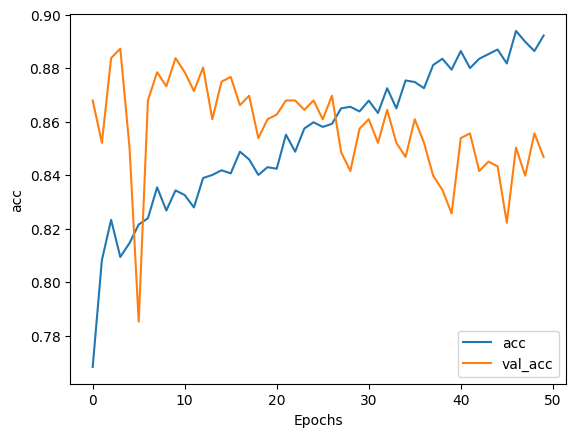

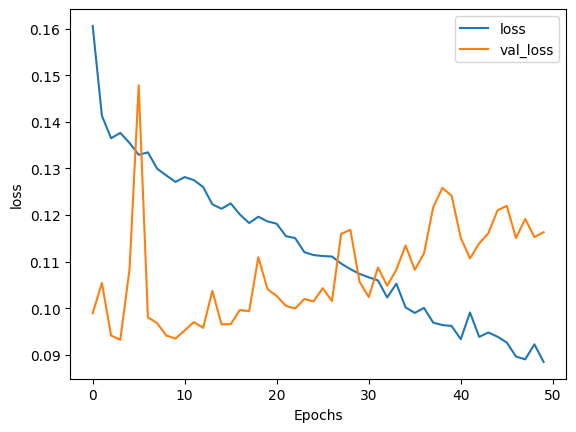

In [25]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [26]:
model.save("model_capstone.h5")

d:\Study\Bangkit\Capstone_ml\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
